<a href="https://colab.research.google.com/github/wonseokb/Genat4_Study/blob/main/10%20-%20Unsupervised(HW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/UT-GEOML/GEO391/blob/main/10-Unsupervised.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Unsupervised Learning

![](https://qph.fs.quoracdn.net/main-qimg-c7e3ab8ca3f5c33f11a0f8828f06d1b2)

* https://www.quora.com/What-is-classification-and-regression-in-machine-learning

We saw two examples of machine-learning problems so far: regression and classification. Both can be addressed using deep learning and convolutional neural networks. Both are examples of *supervised learning*: the neural network finds its parameters by fitting the output of the network to predefined training outputs.

Supervised learning is difficult in the case of geoscience problems, because we often deal with data from remote measurements and do not have an immediate access to the ground truth. We solved this problem by generating data for training using either previous manual interpretations or synthetic modeling.

It is also possible to extract information from the training data without predefined outputs. This approach is known as *unsupervised* learning. 

![Screenshot%202023-03-24%20at%2011.35.53%20AM.png](attachment:Screenshot%202023-03-24%20at%2011.35.53%20AM.png)

https://bard.google.com/

The text above was generated by Google Bard, a chatbot competing with ChatGPT and based on LLM (Large Language Model.)
These models are examples of unsupervised learning trained on different text examples to be able to extract patterns and generate human-like texts.

## Revisiting well-log analysis

Let us take another look at the well-log data that we used previously for lithology classification.

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/seg/2016-ml-contest/master/facies_vectors.csv'
data = pd.read_csv(url)
data.head()

,Facies,Formation,Well Name,Depth,GR,ILD_log10,DeltaPHI,PHIND,PE,NM_M,RELPOS
0,3,A1 SH,SHRIMPLIN,2793.0,77.45,0.664,9.9,11.915,4.6,1,1.000
1,3,A1 SH,SHRIMPLIN,2793.5,78.26,0.661,14.2,12.565,4.1,1,0.979
2,3,A1 SH,SHRIMPLIN,2794.0,79.05,0.658,14.8,13.050,3.6,1,0.957
3,3,A1 SH,SHRIMPLIN,2794.5,86.10,0.655,13.9,13.115,3.5,1,0.936
4,3,A1 SH,SHRIMPLIN,2795.0,74.58,0.647,13.5,13.300,3.4,1,0.915


This time, we are going to ignore the core analysis information and assume that we only have well-log information. What can we learn from it about the rocks in the subsurface?

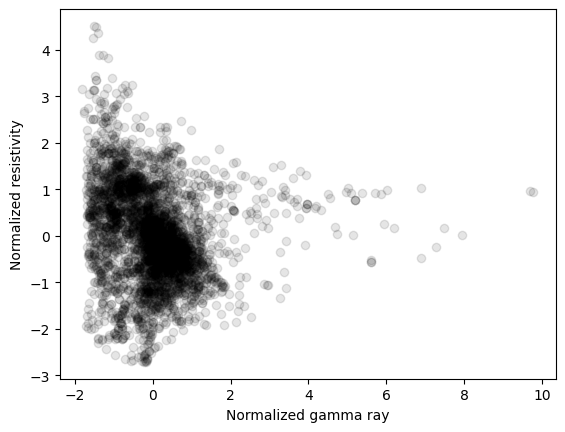

In [ ]:
import matplotlib.pyplot as plt
from sklearn import preprocessing

# select only two logs
x2 = data.loc[:, ['GR', 'ILD_log10']]
# scale to zero mean and unit variance
scaler = preprocessing.StandardScaler()
x2 = scaler.fit(x2).transform(x2)

# plot to check
plt.scatter(x2[:, 0], x2[:, 1], color='k', alpha=0.1)
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized resistivity')
plt.show()

Previously, we saw this picture in color, corresponding to different facies. If we don't have access to this information, we can still divide the data points into different classes using clustering analysis. 

*Clustering* is a classic example of unsupervised learning.

## Clustering by K-means

We used k-NN (k nearest neighbors) algorithm previously for classification. A related algorithm, known as *k-means*, works for unsupervised clustering.

In [ ]:
from sklearn.cluster import KMeans

# requested number of clusters
n_clusters = 4

# use random_state for reproducibility
k_means = KMeans(n_clusters=n_clusters,
                 random_state=2023)

In [ ]:
KMeans?

In [ ]:
k_means.fit(x2)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=2023)

In [ ]:
labels = k_means.labels_
print(len(labels), set(labels))

4149 {0, 1, 2, 3}


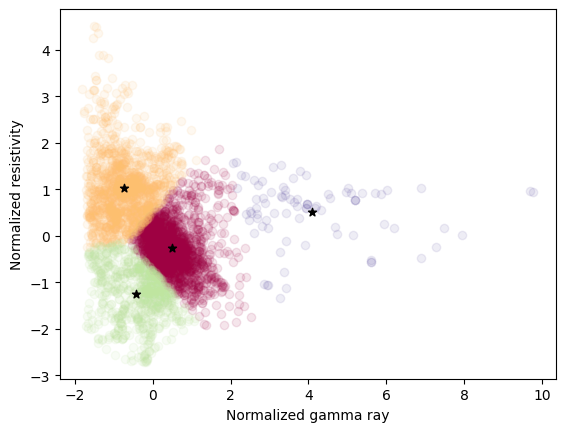

In [ ]:
import numpy as np

# generate colors for different clusters
colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))
centers = k_means.cluster_centers_

for k, col in enumerate(colors):
    plt.scatter(x2[labels == k, 0], x2[labels == k, 1], color=col, alpha=0.1)
    # plots the centroids
    plt.scatter(centers[k][0], centers[k][1], color='k', marker='*')
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized resistivity')
plt.show()

## How does it work?

The k-means algorithm looks for $k$ centers (means) and divides the data into clusters with each cluster assigned to the nearest center.

It works iteratively:
1. Start with some distribution of centers, possibly random.
2. Divide the data into clusters and compute the mean point for each cluster.
3. If the mean point of a cluster does not coincide with its center, move the center.
4. Repeat step 2.

As a result, the data space is partitioned into polygonal regions corresponding to the nearest center (Voronoi diagram).

![](https://mathworld.wolfram.com/images/eps-gif/VoronoiDiagramPlots_800.gif)
* https://mathworld.wolfram.com/VoronoiDiagram.html

In [ ]:
import matplotlib.colors
cmap = matplotlib.colors.ListedColormap(colors)
scatter_colors = [colors[c] for c in labels]
xc = [centers[:]]

# create 400 x 400 grid
G = np.linspace(x2[:, 0].min(), x2[:, 0].max(), 400)
R = np.linspace(x2[:, 0].min(), x2[:, 1].max(), 400)
G, R = np.meshgrid(G, R)
# find a cluster for every point
grid = np.array([G.ravel(), R.ravel()]).T
F = k_means.predict(grid).reshape(G.shape)

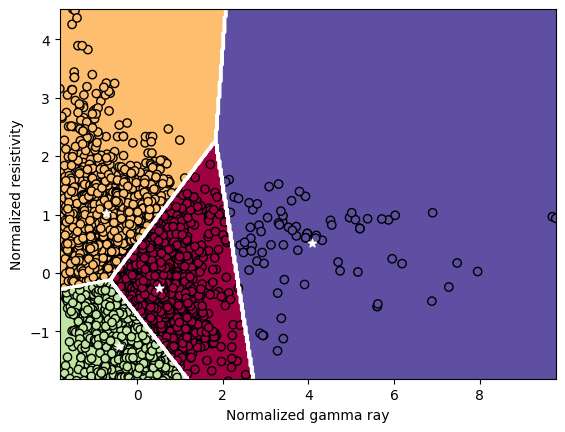

In [ ]:
# overlay map and scatter plot
plt.contourf(G, R, F, cmap=cmap)
plt.contour(G, R, F, linewidths=2, colors='w')
plt.scatter(x2[:, 0], x2[:, 1], c=scatter_colors, edgecolors='k')
plt.scatter(centers[:, 0], centers[:, 1], color='w', marker='*')
plt.axis([G.min(), G.max(), R.min(), R.max()])
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized resistivity')
plt.show()

Do different regions correspond to different rocks? Not necessarily. But the clusters allow us to group all data points into specific categories.

## Deciding on the number of clusters

The immediate measure for evaluating k-means clustering is *inertia*: the sum of the squared distances between each point and its nearest cluster center.

Inertia can be used to try estimating an appropriate number of clusters.

In [ ]:
print(k_means.inertia_, k_means.score(x2))

2806.3058275907842 -2806.3058275907842


In [ ]:
inertias = []
ks = list(range(2, 9))
for k in ks:
    km = KMeans(n_clusters=k, random_state=2023)
    km.fit(x2)
    inertias.append(km.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

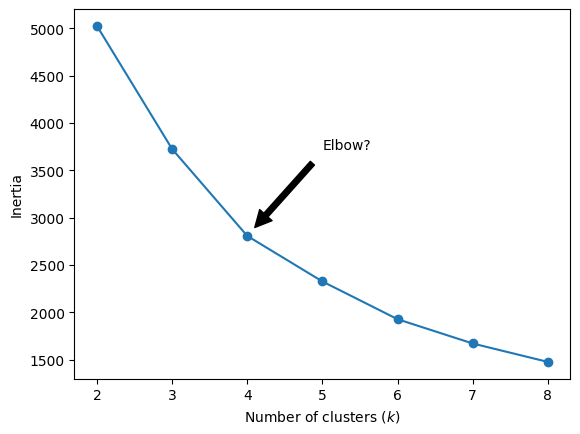

In [ ]:
plt.plot(ks, inertias, 'o-')
plt.annotate('Elbow?',
             xy=(4, inertias[2]),
             xytext=(5, inertias[1]),
             arrowprops={'facecolor': 'black', 'shrink': 0.1})
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Inertia')
plt.show()

## <div style="color:red">Task 1</div>

Instead of using only two logs (<code>['GR','ILD_log10']</code>), perform clustering using five logs (<code>['GR','ILD_log10','DeltaPHI','PHIND','PE']</code>), dropping wells that don't have PE logs.

You will not be able to plot results in the 5-D space, but you can plot intertia to decide on the optimal number of clusters.

In [ ]:
import matplotlib.pyplot as plt
from sklearn import preprocessing

# select only two logs
x2_task1 = data.loc[:, ['GR', 'ILD_log10','DeltaPHI','PHIND','PE']]
# scale to zero mean and unit variance
scaler = preprocessing.StandardScaler()
x2_task1 = scaler.fit(x2_task1).transform(x2_task1)

In [ ]:
print(x2_task1.shape)
print(type(x2_task1))

(4149, 5)
<class 'numpy.ndarray'>


In [ ]:
# convert numpy array to DataFrame
data_train = pd.DataFrame(x2_task1)

# print the DataFrame
print(data_train)

          GR  ILD_log10  DeltaPHI   PHIND     PE
0     77.450      0.664     9.900  11.915  4.600
1     78.260      0.661    14.200  12.565  4.100
2     79.050      0.658    14.800  13.050  3.600
3     86.100      0.655    13.900  13.115  3.500
4     74.580      0.647    13.500  13.300  3.400
...      ...        ...       ...     ...    ...
4144  46.719      0.947     1.828   7.254  3.617
4145  44.563      0.953     2.241   8.013  3.344
4146  49.719      0.964     2.925   8.013  3.190
4147  51.469      0.965     3.083   7.708  3.152
4148  50.031      0.970     2.609   6.668  3.295

[4149 rows x 5 columns]


In [ ]:
has_pe = ~data_train['PE'].isna()
data_train_pe = data_train[has_pe]
data_train_pe.describe()

,GR,ILD_log10,DeltaPHI,PHIND,PE
count,3232.000000,3232.000000,3232.000000,3232.000000,3232.000000
mean,66.135769,0.642719,3.559642,13.483213,3.725014
std,30.854826,0.241845,5.228948,7.698980,0.896152
min,13.250000,-0.025949,-21.832000,0.550000,0.200000
25%,46.918750,0.492750,1.163750,8.346750,3.100000
50%,65.721500,0.624437,3.500000,12.150000,3.551500
75%,79.626250,0.812735,6.432500,16.453750,4.300000
max,361.150000,1.480000,18.600000,84.400000,8.094000


In [ ]:
x2_task1 = data_train_pe.values

In [ ]:
print(x2_task1.shape)
print(type(x2_task1))

(3232, 5)
<class 'numpy.ndarray'>


In [ ]:
from sklearn.cluster import KMeans

# requested number of clusters
n_clusters = 4

# use random_state for reproducibility
k_means = KMeans(n_clusters=n_clusters,
                 random_state=2023)

In [ ]:
KMeans?

In [ ]:
k_means.fit(x2_task1)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=4, random_state=2023)

In [ ]:
labels = k_means.labels_
print(len(labels), set(labels))

3232 {0, 1, 2, 3}


In [ ]:
print(k_means.inertia_, k_means.score(x2_task1))

697700.7250654816 -697700.7250654816


In [ ]:
inertias = []
ks = list(range(2, 9))
for k in ks:
    km = KMeans(n_clusters=k, random_state=2023)
    km.fit(x2_task1)
    inertias.append(km.inertia_)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: F

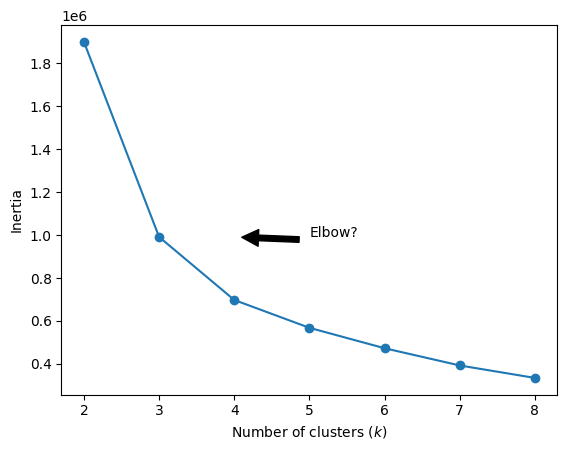

In [ ]:
plt.plot(ks, inertias, 'o-')
plt.annotate('Elbow?',
             xy=(4, inertias[1]),
             xytext=(5, inertias[1]),
             arrowprops={'facecolor': 'black', 'shrink': 0.1})
plt.xlabel('Number of clusters ($k$)')
plt.ylabel('Inertia')
plt.show()

###It looks we need 3(or4) clusters because it looks elbwow

We can also test if there is any statistical dependence between clusters and lithofacies using the statistical chi-squared ($\chi^2$) test.

* https://en.wikipedia.org/wiki/Pearson%27s_chi-squared_test

In [ ]:
data['Clusters'] = labels
contingency = pd.crosstab(data.Facies, data.Clusters)
contingency

IndexError: ignored

In [ ]:
from scipy.stats import chi2_contingency

stat, p, dof, expected = chi2_contingency(contingency)
print(pd.DataFrame(expected))
print('statistic = {}, '
      'p-value = {}, '
      'degress of freedom = {}'.format(stat, p, dof))

            0           1           2          3
0  126.539407   87.783080   48.251627   5.425886
1  443.832249  307.895879  169.240781  19.031092
2  368.286334  255.488069  140.433839  15.791757
3  127.955893   88.765727   48.791757   5.486623
4  139.759942   96.954447   53.292842   5.992769
5  274.798265  190.633406  104.785249  11.783080
6   66.574837   46.184382   25.386117   2.854664
7  323.903109  224.698482  123.509761  13.888648
8   87.349964   60.596529   33.308026   3.745481
statistic = 2849.962514029358, p-value = 0.0, degress of freedom = 24


Small $p$-value justifies rejecting the null hypothesis of statistical independence. It appears that clusters and lithofacies are indeed dependent.

In [ ]:
chi2_contingency?

## Clustering by DBSCAN

Of course, k-means is not the only clustering algorithm. There is a variety of other options.

We can try, for example, DBSCAN (Density-Based Spatial Clustering of Applications with Noise). Unlike k-means, DBSCAN is a deterministic algorithm. It is aimed on finding high-density agglomerations of data and expands from them to define clusters.

* Schubert, E., Sander, J., Ester, M., Kriegel, H.P. and Xu, X., 2017. [DBSCAN revisited, revisited: why and how you should (still) use DBSCAN](https://dl.acm.org/doi/10.1145/3068335). ACM Transactions on Database Systems (TODS), 42(3), pp.1-21.

In [ ]:
from sklearn.cluster import DBSCAN

db = DBSCAN(eps=0.4, min_samples=5).fit(x2)
set(db.labels_)

{-1, 0, 1, 2}

In [ ]:
DBSCAN?

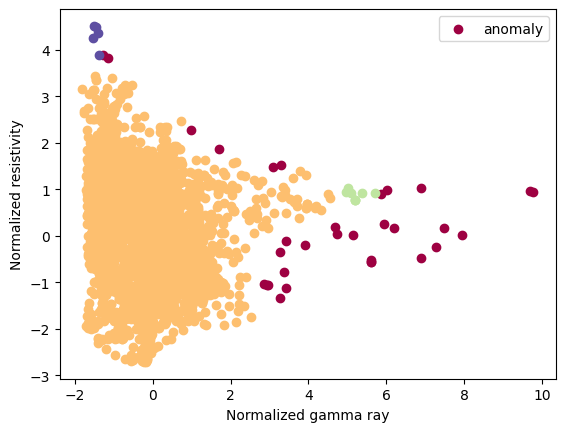

In [ ]:
# find number of clusters
n_db_clusters = len(set(db.labels_))

# set colors
db_colors = plt.cm.Spectral(np.linspace(0, 1, n_db_clusters))

for k in range(n_db_clusters):
    plt.scatter(x2[db.labels_ == k-1, 0],
                x2[db.labels_ == k-1, 1],
                color=db_colors[k],
                label=(None, 'anomaly')[k == 0])
plt.legend()
plt.xlabel('Normalized gamma ray')
plt.ylabel('Normalized resistivity')
plt.show()

## Revisiting seismic wavelet analysis

For another application, we can revisit the problem of picking horizons in seismic data. In the supervised setting, we use manual picks of the seafloor horizon as training labels.

In an unsupervised setting, we assume that no picks are available for training. We will extract all wavelets and try to detect patterns in them for clustering analysis.

The seismic data are available at https://drive.google.com/file/d/14mEdg3hU5y69CpkUP-vCNnKzqmSf5zs2/view?usp=sharing

In [ ]:
pip install segpy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.8/74.8 KB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.6/49.6 KB 3.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 112.7/112.7 KB 7.4 MB/s eta 0:00:00
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13721 sha256=01a4f97f4718e491a021fa3858cf19460197e315bbc1b3beced1e6a1722e00b5
  Stored in directory: /root/.cache/pip/wheels/70/4a/46/1309fc853b8d395e60bafaf1b6df7845bdd82c95fd59dd8d2b
Successfully built docopt


In [ ]:
import os
from segpy.reader import create_reader

import os
from google.colab import drive

# Mount the Google Drive to access files
drive.mount('/content/drive')

# Set the directory path where CSV files are located
dirname = '/content/drive/My Drive/'

#from google.colab import drive
# drive.mount('/content/gdrive')

# change the directory name below to your local path
#dirname = '/content/drive/My Drive'
#dirname = '/content/gdrive/My Drive'
#dirname = '/Users/sergey/Downloads'
# Seismic data resampled to 16-bit SEGY format
filename = 'class2021_16_bit2.sgy'
segy = open(os.path.join(dirname, filename), 'rb')
reader = create_reader(segy)
print(reader.num_traces())  # should output 697761

Mounted at /content/drive


INFO:segpy.reader:Successfully unpickled reader for /content/drive/My Drive/class2021_16_bit2.sgy


697761


In [ ]:
import numpy as np

# get cube dimensions
nt = reader.max_num_trace_samples()  # samples in a trace
n_inlines = reader.num_inlines()  # number of inlines
n_xlines = reader.num_xlines()  # number of crosslines
print(nt, n_inlines, n_xlines)

ntmax = 1001  # top half of the section


def read_slice(inline):
    'read one inline slice'
    section = np.zeros((nt, n_xlines))
    for i in range(n_xlines):
        section[:, i] = reader.trace_samples(inline*n_xlines + i)
    return section[:ntmax]

2001 1161 601


In [ ]:
import matplotlib.pyplot as plt

dt = 0.004  # time sampling in seconds
dx = 0.025  # trace sampling in kilometers


def plot_seismic(section, title, cmap='gray'):
    plt.imshow(section, cmap=cmap, vmin=-2000, vmax=2000, aspect=0.5)
    yticks = np.arange(0, section.shape[0], 250)
    ytick_labels = [str(dt*k) for k in yticks]
    plt.yticks(ticks=yticks, labels=ytick_labels)
    plt.ylabel('two-way traveltime (s)', fontsize=14)
    xticks = np.arange(0, section.shape[1], 100)
    xtick_labels = [str(dx*k) for k in xticks]
    plt.xticks(ticks=xticks, labels=xtick_labels)
    plt.xlabel('distance (km)', fontsize=14)
    plt.title(title, fontsize=20)

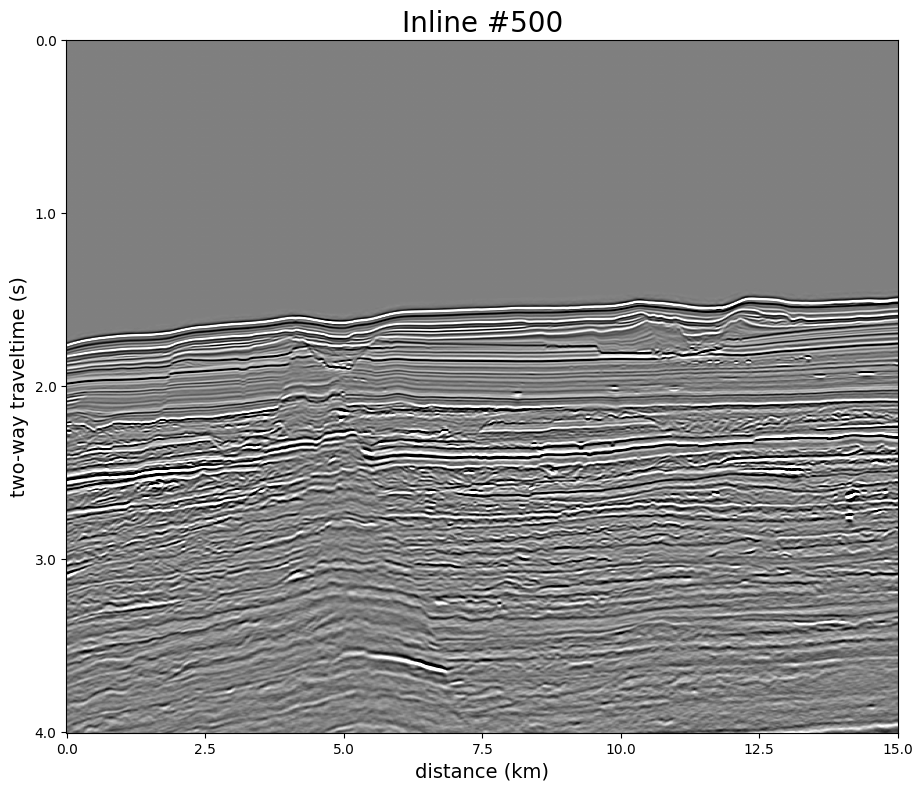

In [ ]:
seismic = read_slice(500)

plt.figure(figsize=(15, 9))
plot_seismic(seismic, 'Inline #500')
plt.show()

For extracting wavelets, we can use local maxima of the envelope attribute.

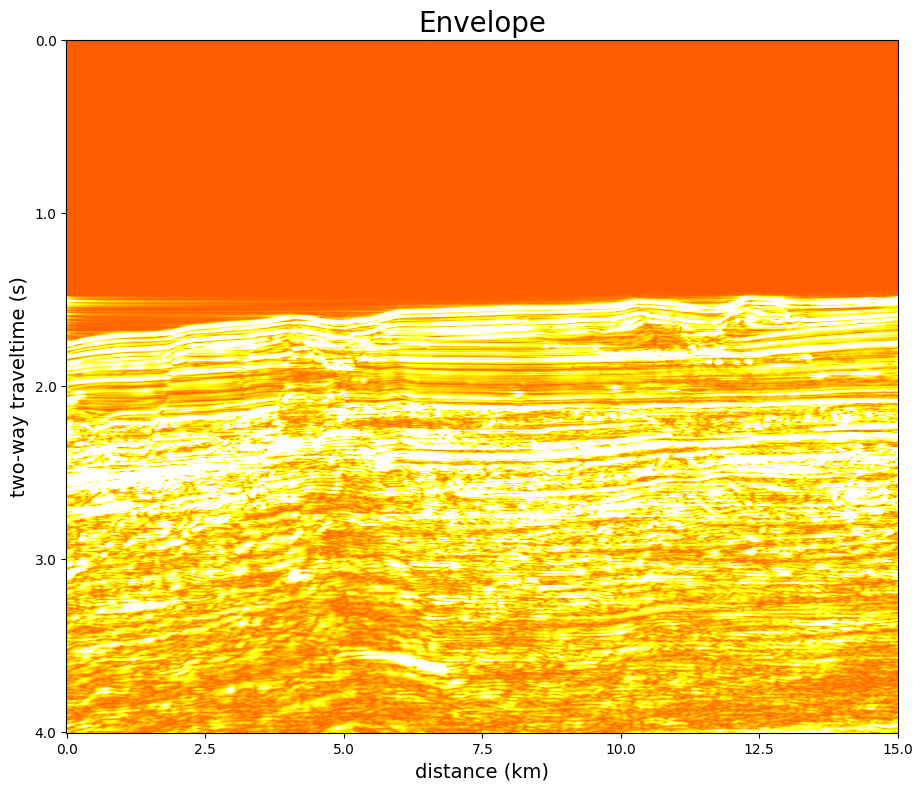

In [ ]:
from scipy.signal import hilbert
envelope = np.abs(hilbert(seismic))

plt.figure(figsize=(15, 9))
plot_seismic(envelope, 'Envelope', cmap='hot')
plt.show()

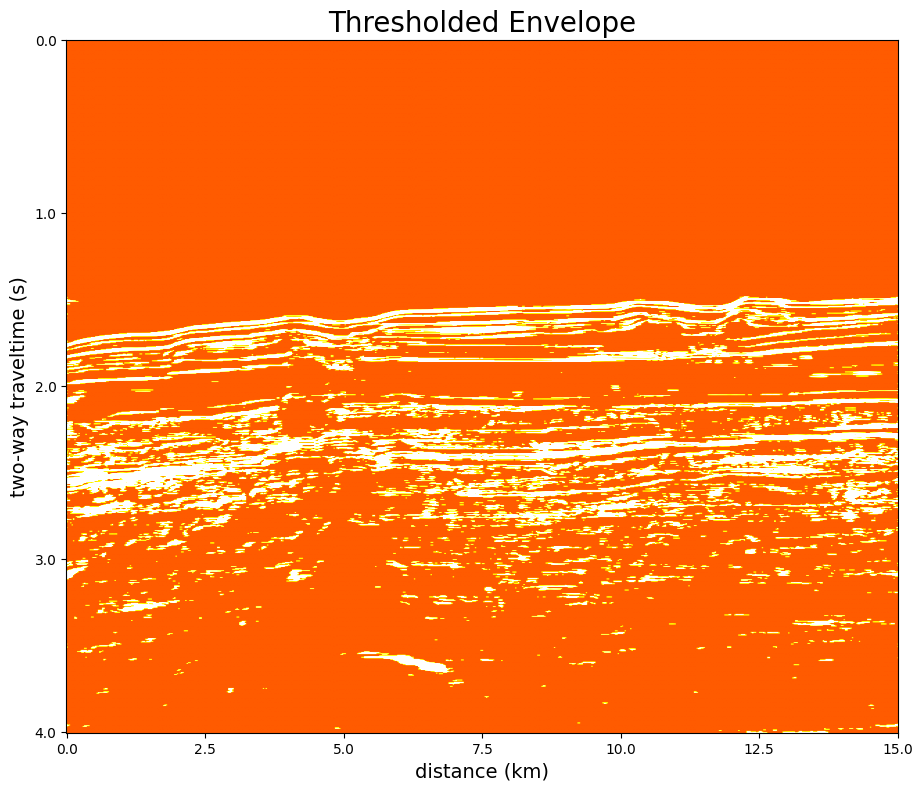

In [ ]:
# keep only envelope above 90% percentile
threshold = np.quantile(envelope, 0.9)
envelope_t = envelope[:]
envelope_t[envelope < threshold] = 0

plt.figure(figsize=(15, 9))
plot_seismic(envelope_t, 'Thresholded Envelope', cmap='hot')
plt.show()

In [ ]:
from scipy.signal import find_peaks

wavelets = []
picks = []

nw = 41  # wavelet length

ntraces = seismic.shape[1]
for k in range(ntraces):
    trace = seismic[:, k]
    etrace = envelope_t[:, k]
    # find local maxima
    peaks, _ = find_peaks(etrace)
    for peak in peaks:
        if peak > nw and peak < ntmax-nw:
            wavelet = trace[peak-nw//2:peak+nw//2+1]
            if wavelet[nw//2] == wavelet.max():
                wavelets.append(wavelet)
                picks.append((k, peak))

print('Extracted {} wavelets'.format(len(wavelets)))

Extracted 3021 wavelets


In [ ]:
def plot_wavelets(wavelets, traces, title):
    nw = len(wavelets[0])
    ncols = len(traces)
    f, ax = plt.subplots(nrows=1, ncols=ncols, figsize=(16, 8))
    twt = np.arange(-nw//2+1, nw//2+1)*dt
    for trace in range(ncols):
        axt = ax[trace]
        # plot as curve
        amp = wavelets[traces[trace]]
        axt.plot(amp, twt, 'k')
        axt.set_ylim(twt.max(), twt.min())
        if trace == 0:
            axt.set_ylabel('Time (s)')
        else:
            axt.set_yticklabels([])
        axt.set_xticks([])
    f.suptitle(title, fontsize=25)
    plt.show()

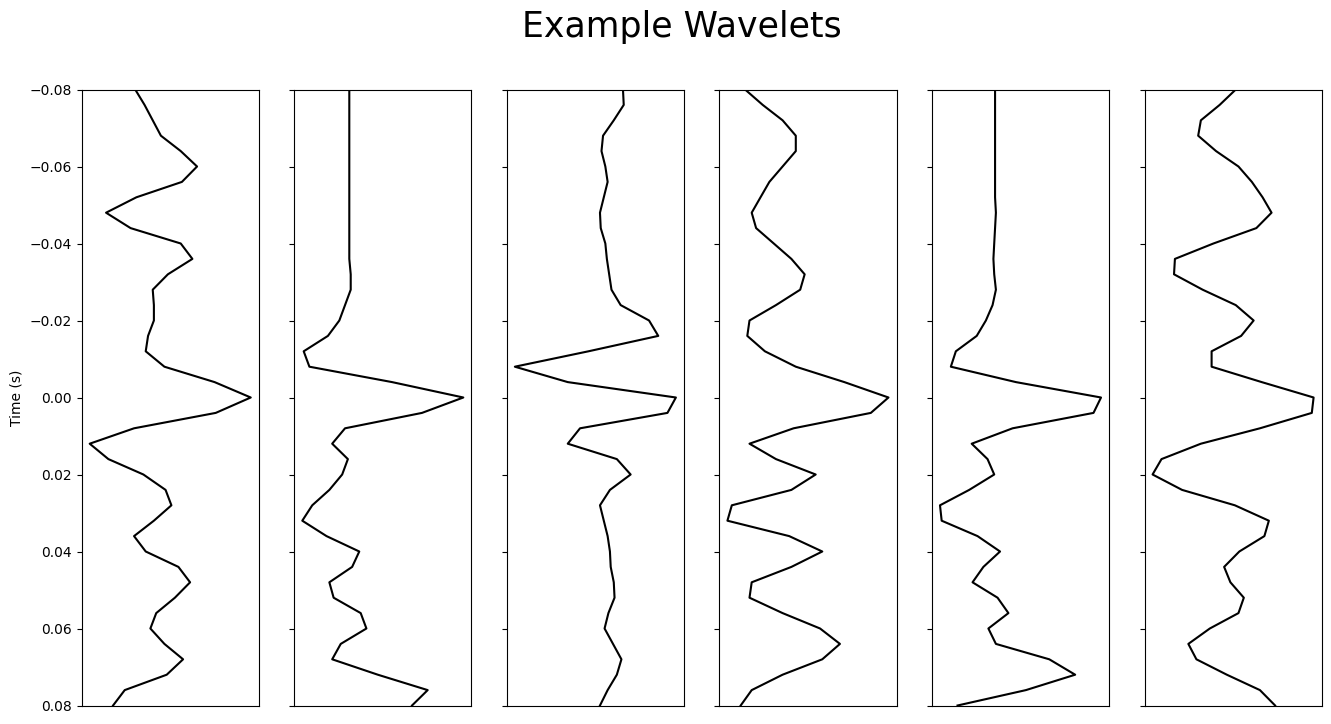

In [ ]:
plot_wavelets(wavelets, np.arange(100, 601, 100), 'Example Wavelets')

We could try to cluster 3,021 wavelets directly (in 41-dimensional space), but the wavelets contain details that may not be important for their identification. A better idea is to try to extract their essential patterns by projecting them first to a lower-dimensional space.

## Principal Component Analysis

PCA (Principal Component Analysis) projects the data into a lower-dimensional space using SVD (Singular Value Decomposition), a classic tool from numerical linear algebra.

* https://en.wikipedia.org/wiki/Singular_value_decomposition

![](https://upload.wikimedia.org/wikipedia/commons/thumb/c/c8/Singular_value_decomposition_visualisation.svg/512px-Singular_value_decomposition_visualisation.svg.png)

In [ ]:
from sklearn.decomposition import PCA
wavelets = np.array(wavelets)


pca = PCA()
pca.fit(wavelets)

PCA()

In [ ]:
PCA?

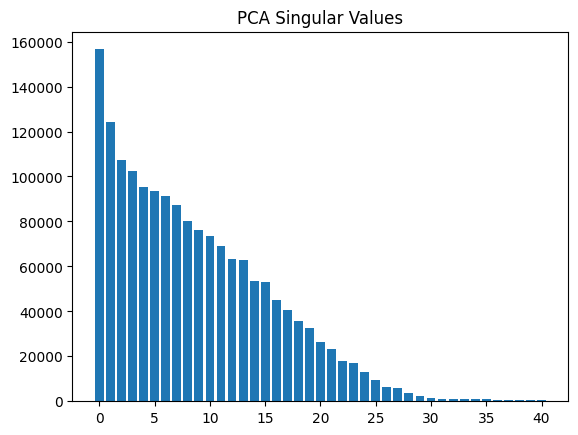

In [ ]:
plt.bar(np.arange(nw), pca.singular_values_)
plt.title('PCA Singular Values')
plt.show()

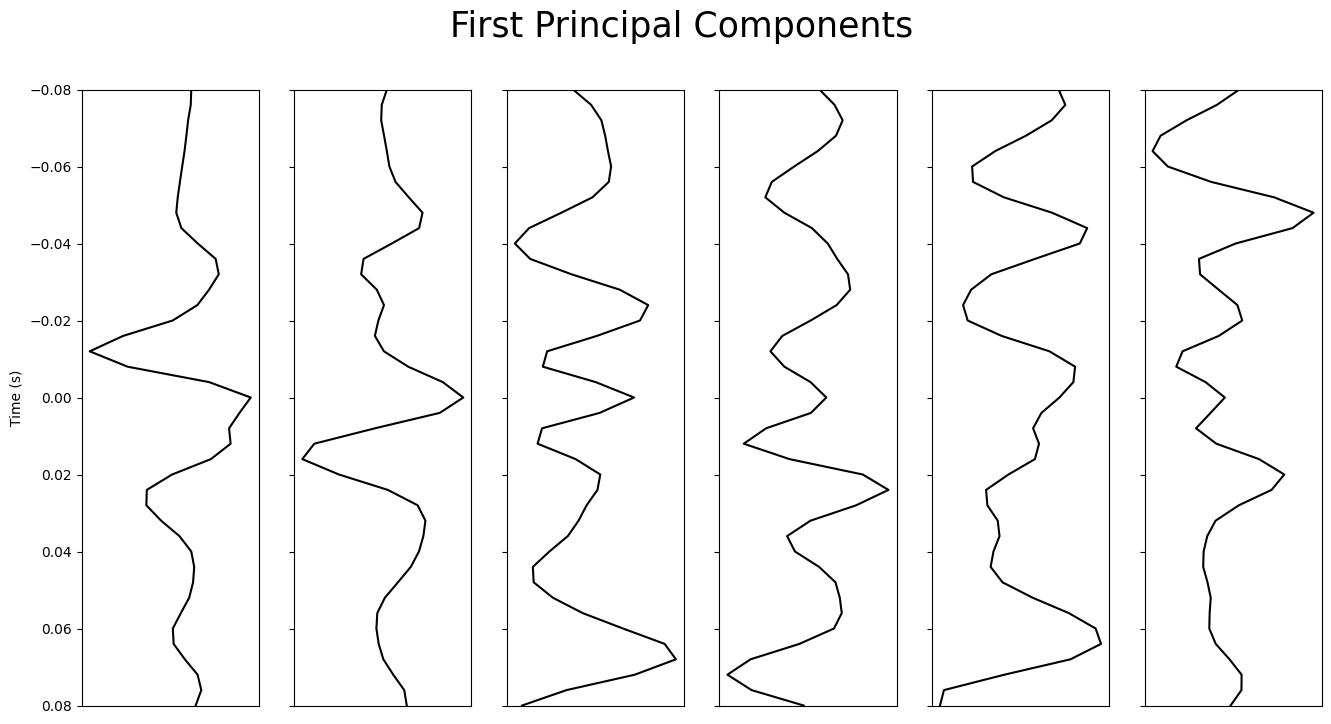

In [ ]:
plot_wavelets(pca.components_, np.arange(6), 'First Principal Components')

In [ ]:
pca8 = PCA(n_components=8)
wavelets8 = pca8.fit_transform(wavelets)
wavelets8.shape

(3021, 8)

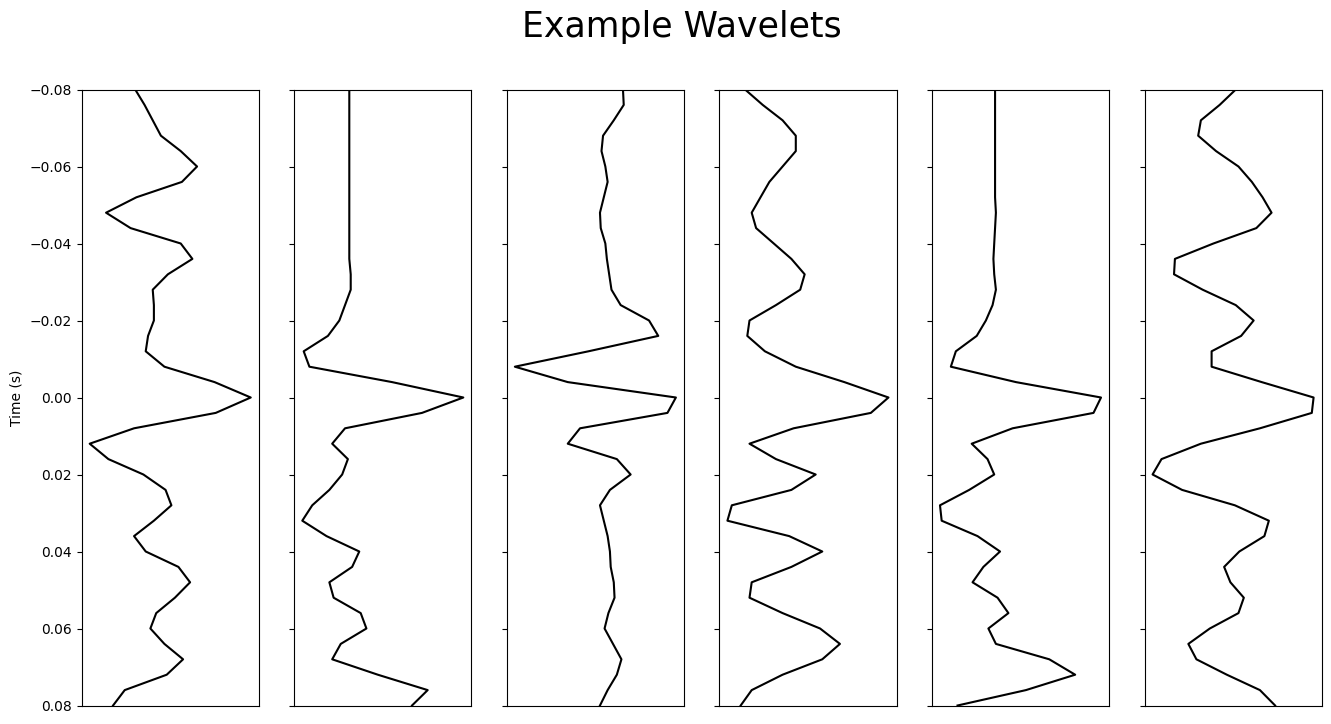

In [ ]:
wavelets_pca = pca8.inverse_transform(wavelets8)

plot_wavelets(wavelets, np.arange(100, 601, 100), 'Example Wavelets')

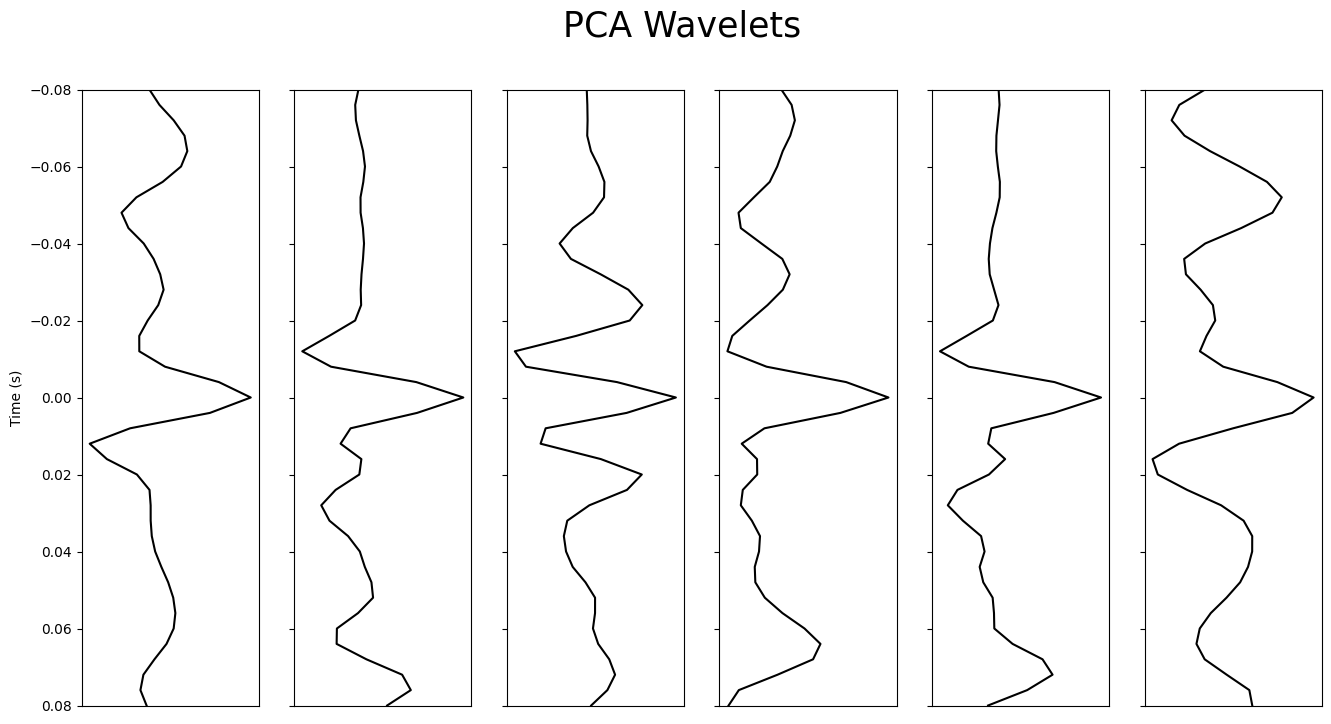

In [ ]:
plot_wavelets(wavelets_pca, np.arange(100, 601, 100), 'PCA Wavelets')

Having reduced the dimensionality from 21 to 8 by removing unimportant details, we can perform a better job of clustering our data (now in 8-dimensional space.)

## Autoencoder

PCA is a powerful dimensionality-reduction technique but it is limited by the linearity assumption. A more powerful approach involves the use of neural networks.

Recall the simple network we used for classifying wavelets

In [ ]:
from tensorflow import keras

classification_model = keras.Sequential(
    [
        keras.Input(shape=(nw,)),
        keras.layers.Dense(8, activation='relu'),
        keras.layers.Dense(1, activation='sigmoid'),
    ]
)

classification_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 8)                 336       
                                                                 
 dense_1 (Dense)             (None, 1)                 9         
                                                                 
Total params: 345
Trainable params: 345
Non-trainable params: 0
_________________________________________________________________


In the process of classification, we were reducing the data size from 21 to 8 to extract the most important patterns. The idea of *autoencoding* is to follow this reduction (encoding) with extension back to the original size (decoding) and fitting the original data.  

![](https://miro.medium.com/max/4800/1*44eDEuZBEsmG_TCAKRI3Kw@2x.png)
https://towardsdatascience.com/applied-deep-learning-part-3-autoencoders-1c083af4d798

In [ ]:
input_wavelets = keras.Input(shape=(nw,))
encoded = keras.layers.Dense(8, activation='relu')(input_wavelets)
decoded = keras.layers.Dense(nw, activation='tanh')(encoded)

encoder = keras.Model(input_wavelets, encoded)
autoencoder = keras.Model(input_wavelets, decoded)

encoded_input = keras.Input(shape=(8,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

autoencoder.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 41)]              0         
                                                                 
 dense_2 (Dense)             (None, 8)                 336       
                                                                 
 dense_3 (Dense)             (None, 41)                369       
                                                                 
Total params: 705
Trainable params: 705
Non-trainable params: 0
_________________________________________________________________


Because we are going to be fitting the input dataset to itself, we can treat it as a regression problem (technically, autoregression) and use MSE (mean squared error) as the loss function. 

In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

We can prepare the data for training by randomly shuffling and normalizing by maximum value.

In [ ]:
import tensorflow.random
import random

# for reproducibility
tensorflow.random.set_seed(2023)
np.random.seed(2023)
random.seed(2023)  

# randomly shuffle wavelets and picks together
zipped = list(zip(wavelets, picks))
random.shuffle(zipped)
wavelets_r, picks_r = zip(*zipped)

# convert to numpy and normalize by maximum
wavelets_n = np.array(wavelets_r)
wavelets_n = wavelets_n/np.max(wavelets_n)

In [ ]:
# fit the model
batch_size = 10
epochs = 10

# autoencoder fits data to itself
fit = autoencoder.fit(wavelets_n, wavelets_n,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.3)

Epoch 1/10
212/212 [==============================] - 2s 3ms/step - loss: 0.0035 - val_loss: 0.0029
Epoch 2/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0027 - val_loss: 0.0023
Epoch 3/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0021 - val_loss: 0.0019
Epoch 4/10
212/212 [==============================] - 0s 2ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 5/10
212/212 [==============================] - 1s 2ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 6/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 7/10
212/212 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 8/10
212/212 [==============================] - 1s 2ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 9/10
212/212 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 10/10
212/212 [==============================] - 1s 2ms/step - loss: 0.0013 - val_loss: 0.0013

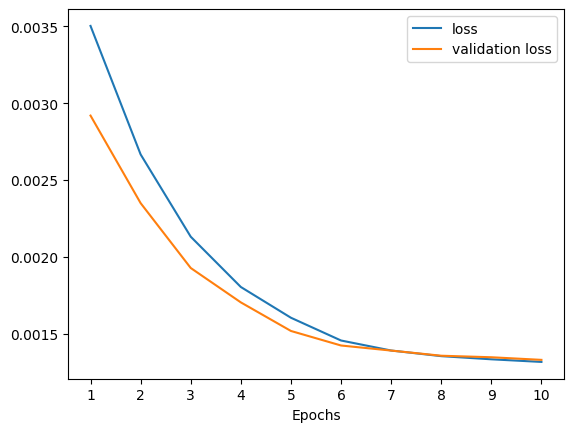

In [ ]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

In [ ]:
encoded_wavelets = encoder.predict(wavelets_n)
encoded_wavelets.shape

95/95 [==============================] - 0s 2ms/step


(3021, 8)

In [ ]:
# Create the decoder model
encoded_input = keras.Input(shape=(8,))
decoder_layer = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer(encoded_input))

decoded_wavelets = decoder.predict(encoded_wavelets)

95/95 [==============================] - 0s 2ms/step


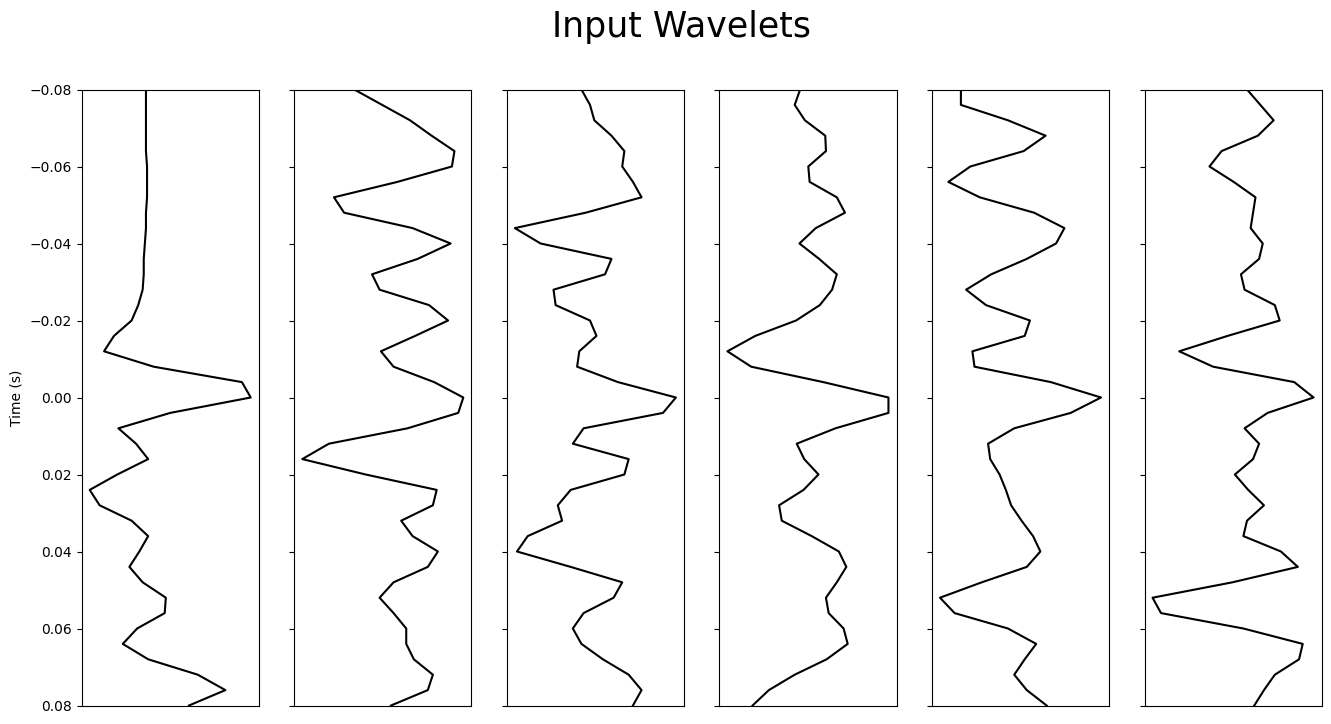

In [ ]:
plot_wavelets(wavelets_n, np.arange(100, 601, 100), 'Input Wavelets')

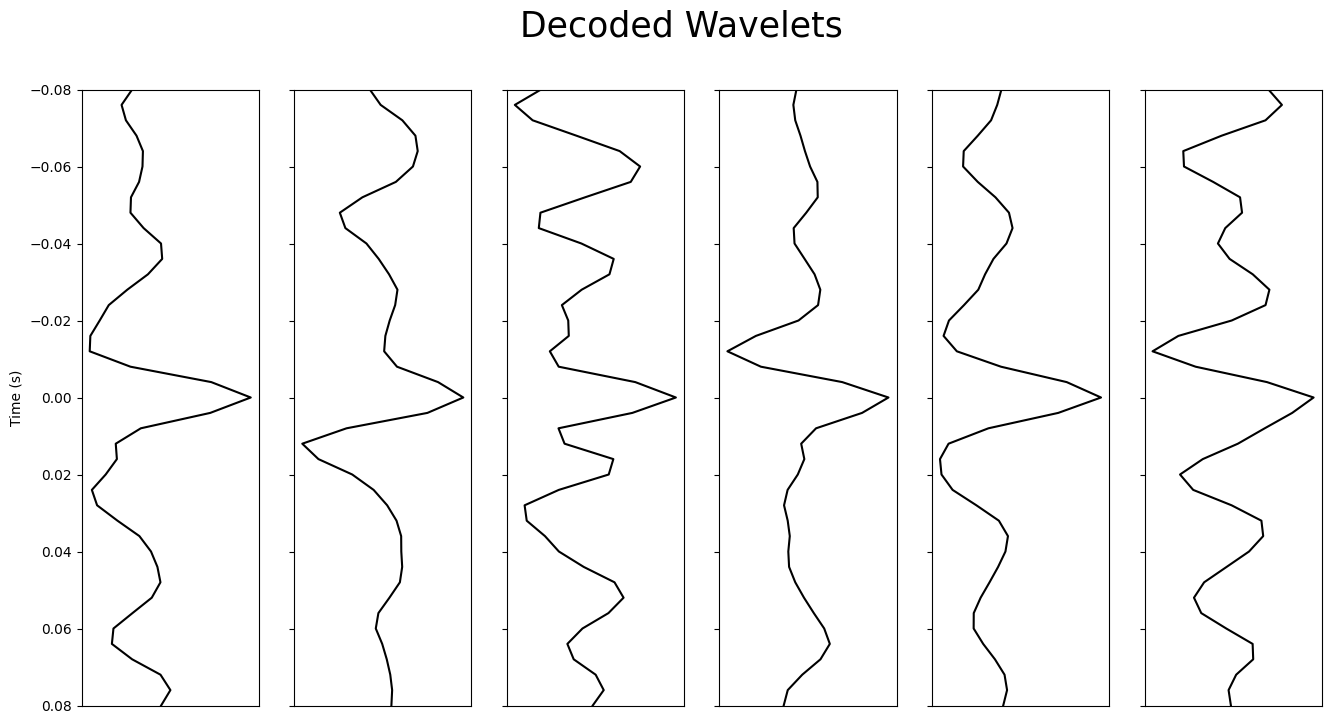

In [ ]:
plot_wavelets(decoded_wavelets, np.arange(100, 601, 100), 'Decoded Wavelets')

## Clustering latent space

We can now cluster the data in the 8-dimensional latent space using one of the standard clustering techniques, such as k-means.

In [ ]:
n_clusters = 5

# use random_state for reproducibility
k_means = KMeans(n_clusters=n_clusters,
                 random_state=2023)
k_means.fit(encoded_wavelets)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


KMeans(n_clusters=5, random_state=2023)

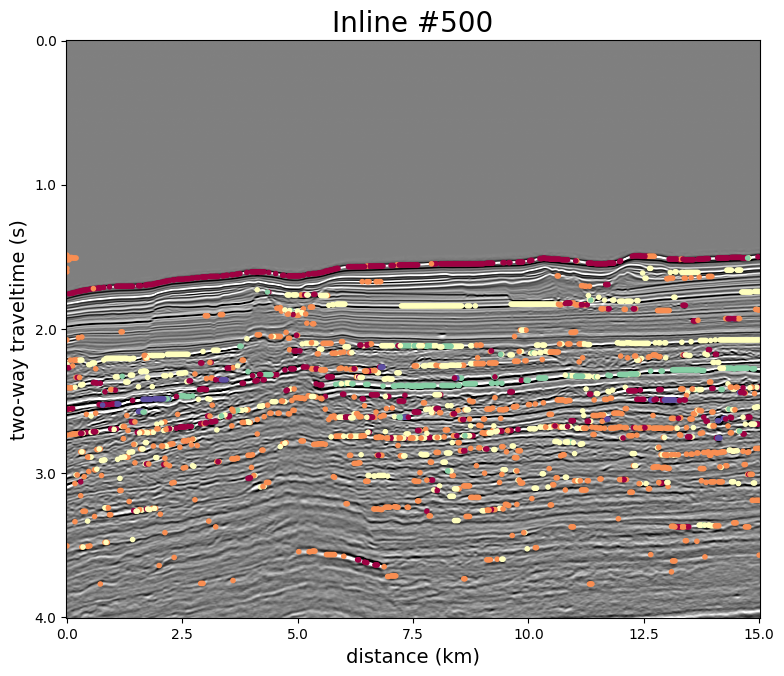

In [ ]:
pick_marks = np.array(picks_r)
pick_colors = plt.cm.Spectral(np.linspace(0, 1, n_clusters))

plt.figure(figsize=(15, 7.5))
plot_seismic(seismic, 'Inline #500')
plt.scatter(pick_marks[:, 0], pick_marks[:, 1],
            color=pick_colors[k_means.labels_],
            marker='.')
plt.show()

Autoencoder-based clustering partially succeeded in picking the seafloor horizon but had less luck with other horizons. It had no prior knowledge of where the horizons should be.

## <div style="color:red">Task 2</div>

Try making the autoencoder network deeper by inserting another hidden layer. For example, instead of going from 41 to 8 in one layer of the encoder part, you can create two layers that go from 41 to 16 and then from 16 to 8. The decoder part will go in the opposite direction: from 8 to 16 and from 16 to 41. 

Does it improve the results? 

In [ ]:
input_wavelets = keras.Input(shape=(nw,))
encoded = keras.layers.Dense(16, activation='relu')(input_wavelets)
encoded = keras.layers.Dense(8, activation='relu')(encoded)
decoded = keras.layers.Dense(16, activation='relu')(encoded)
decoded = keras.layers.Dense(nw, activation='tanh')(decoded)

encoder = keras.Model(input_wavelets, encoded)
autoencoder = keras.Model(input_wavelets, decoded)

encoded_input = keras.Input(shape=(8,))
decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer2(decoder_layer1(encoded_input)))

autoencoder.summary()

Model: "model_26"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_19 (InputLayer)       [(None, 41)]              0         
                                                                 
 dense_36 (Dense)            (None, 16)                672       
                                                                 
 dense_37 (Dense)            (None, 8)                 136       
                                                                 
 dense_38 (Dense)            (None, 16)                144       
                                                                 
 dense_39 (Dense)            (None, 41)                697       
                                                                 
Total params: 1,649
Trainable params: 1,649
Non-trainable params: 0
_________________________________________________________________


In [ ]:
input_wavelets = keras.Input(shape=(41,))
encoded = keras.layers.Dense(20, activation='relu')(input_wavelets)
encoded = keras.layers.Dense(8, activation='relu')(encoded)
decoded = keras.layers.Dense(20, activation='relu')(encoded)
decoded = keras.layers.Dense(41, activation='tanh')(decoded)

encoder = keras.Model(input_wavelets, encoded)
autoencoder = keras.Model(input_wavelets, decoded)

encoded_input = keras.Input(shape=(8,))
decoder_layer1 = autoencoder.layers[-2]
decoder_layer2 = autoencoder.layers[-1]
decoder = keras.Model(encoded_input, decoder_layer2(decoder_layer1(encoded_input)))

autoencoder.summary()

Model: "model_20"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_15 (InputLayer)       [(None, 41)]              0         
                                                                 
 dense_27 (Dense)            (None, 20)                840       
                                                                 
 dense_28 (Dense)            (None, 8)                 168       
                                                                 
 dense_29 (Dense)            (None, 20)                180       
                                                                 
 dense_30 (Dense)            (None, 41)                861       
                                                                 
Total params: 2,049
Trainable params: 2,049
Non-trainable params: 0
_________________________________________________________________


In [ ]:
autoencoder.compile(loss='mse', optimizer='adam')

We can prepare the data for training by randomly shuffling and normalizing by maximum value.

In [ ]:
import tensorflow.random
import random

# for reproducibility
tensorflow.random.set_seed(2023)
np.random.seed(2023)
random.seed(2023)  

# randomly shuffle wavelets and picks together
zipped = list(zip(wavelets, picks))
random.shuffle(zipped)
wavelets_r, picks_r = zip(*zipped)

# convert to numpy and normalize by maximum
wavelets_n = np.array(wavelets_r)
wavelets_n = wavelets_n/np.max(wavelets_n)

In [ ]:
# fit the model
batch_size = 10
epochs = 10

# autoencoder fits data to itself
fit = autoencoder.fit(wavelets_n, wavelets_n,
                      batch_size=batch_size,
                      epochs=epochs,
                      validation_split=0.3)

Epoch 1/10
212/212 [==============================] - 2s 5ms/step - loss: 0.0031 - val_loss: 0.0026
Epoch 2/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0024 - val_loss: 0.0021
Epoch 3/10
212/212 [==============================] - 1s 5ms/step - loss: 0.0019 - val_loss: 0.0017
Epoch 4/10
212/212 [==============================] - 1s 4ms/step - loss: 0.0016 - val_loss: 0.0014
Epoch 5/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0013
Epoch 6/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0013 - val_loss: 0.0012
Epoch 7/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0012
Epoch 8/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0012 - val_loss: 0.0011
Epoch 9/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0011
Epoch 10/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0011 - val_loss: 0.0011

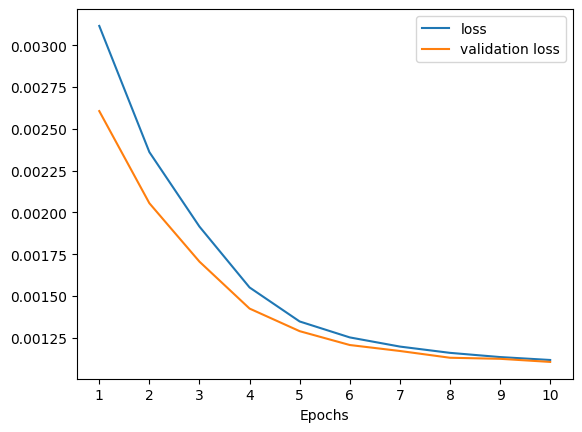

In [ ]:
def plot_loss(fit, epochs):
    iterations = np.arange(1, epochs+1)
    plt.plot(iterations, fit.history['loss'], label='loss')
    plt.plot(iterations, fit.history['val_loss'], label='validation loss')
    plt.legend()
    plt.xticks(iterations[::epochs//10])
    plt.xlabel('Epochs')
    plt.show()


plot_loss(fit, epochs)

### We changed it to have multi-layers, but the result does not get improved.

In [ ]:
encoded_wavelets = encoder.predict(wavelets_n)
encoded_wavelets.shape

95/95 [==============================] - 0s 1ms/step


(3021, 8)

## <div style="color:red">Bonus Task</div>

Apply clustering to the latent (encoded) space created by the variational autoencoder.

## Variational autoencoder

An extention of the autoencoder idea is *variational autoencoder*, a generative model that can produce multiple instances of the data by drawing samples from a statistical distribution in the latent space.

* Doersch, C., 2016. [Tutorial on variational autoencoders](https://arxiv.org/abs/1606.05908). arXiv preprint arXiv:1606.05908.

In [ ]:
from tensorflow.keras import backend

latent_dim = 8  # latent space dimension


class Sampling(keras.layers.Layer):
    'draw sample from distribution'

    def call(self, inputs):
        mean, variance = inputs
        shape = tensorflow.shape(mean)
        epsilon = backend.random_normal(shape=shape)
        return mean + backend.exp(0.5 * variance) * epsilon


# create encoder
inputs = keras.Input(shape=(nw,))
code = keras.layers.Dense(8, activation='relu')(inputs)
mean = keras.layers.Dense(latent_dim)(code)
variance = keras.layers.Dense(latent_dim)(code)
# latent space draws random samples
latent = Sampling()([mean, variance])
va_encoder = keras.Model(inputs, latent)

In [ ]:
# create decoder
latent_inputs = keras.Input(shape=(latent_dim,))
code = keras.layers.Dense(8, activation='relu')(latent_inputs)
outputs = keras.layers.Dense(nw, activation='tanh')(code)
va_decoder = keras.Model(latent_inputs, outputs)

# Variantional autoencoder
outputs = va_decoder(va_encoder(inputs))
vae = keras.Model(inputs, outputs)

In [ ]:
vae.compile(loss='mse', optimizer='adam')

batch_size = 10
epochs = 10

# autoencoder fits data to itself
vae_fit = vae.fit(wavelets_n, wavelets_n,
                  batch_size=batch_size,
                  epochs=epochs,
                  validation_split=0.3)

Epoch 1/10
212/212 [==============================] - 2s 6ms/step - loss: 0.0440 - val_loss: 0.0117
Epoch 2/10
212/212 [==============================] - 1s 4ms/step - loss: 0.0074 - val_loss: 0.0048
Epoch 3/10
212/212 [==============================] - 1s 5ms/step - loss: 0.0042 - val_loss: 0.0037
Epoch 4/10
212/212 [==============================] - 1s 5ms/step - loss: 0.0036 - val_loss: 0.0034
Epoch 5/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0034 - val_loss: 0.0033
Epoch 6/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 7/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 8/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 9/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0033
Epoch 10/10
212/212 [==============================] - 1s 3ms/step - loss: 0.0033 - val_loss: 0.0032

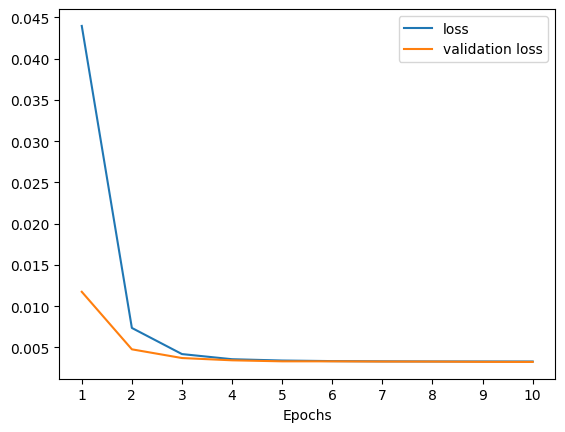

In [ ]:
plot_loss(vae_fit, epochs)

1/1 [==============================] - 0s 56ms/step


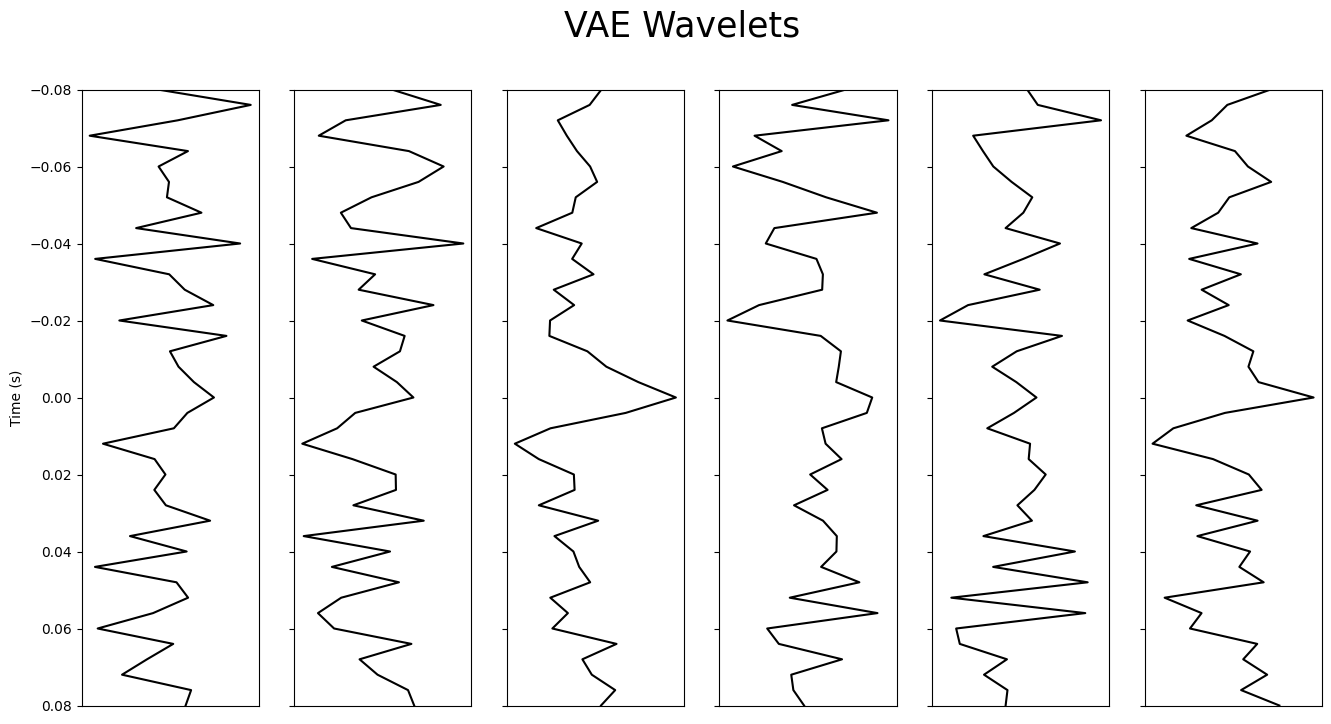

In [ ]:
np.random.seed(2023)
latent = np.random.normal(size=(6, latent_dim))
vae_wavelets = va_decoder.predict(latent)
plot_wavelets(vae_wavelets, np.arange(6), 'VAE Wavelets')